In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt

In [50]:
# !pip install koreanize-matplotlib
%config InlineBackend.figure_format = 'retina'

In [144]:
# 원본 데이터 가져오기
# 컬럼을 추출하기 위해 일단 0행만 가져오기

df = pd.read_parquet("df_final.parquet.gzip")
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id
0,2019-10-16 12:04:37+00:00,view,7900918,2053013556487520725,furniture.kitchen.chair,joie,102.709999,560842110
1,2019-10-16 12:04:37+00:00,view,1003317,2053013555631882655,electronics.smartphone,apple,952.150024,560842739
2,2019-10-16 12:04:37+00:00,view,2501929,2053013564003713919,appliances.kitchen.oven,asel,61.750000,525817175
3,2019-10-16 12:04:37+00:00,view,1004833,2053013555631882655,electronics.smartphone,samsung,172.169998,515456548
4,2019-10-16 12:04:37+00:00,cart,1004836,2053013555631882655,electronics.smartphone,samsung,229.410004,529758564


# 전처리 

In [145]:
df = df.drop_duplicates()
df = df.dropna()

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22146517 entries, 0 to 7074793
Data columns (total 8 columns):
 #   Column         Dtype              
---  ------         -----              
 0   event_time     datetime64[ns, UTC]
 1   event_type     category           
 2   product_id     int64              
 3   category_id    uint64             
 4   category_code  object             
 5   brand          object             
 6   price          float32            
 7   user_id        int64              
dtypes: category(1), datetime64[ns, UTC](1), float32(1), int64(2), object(2), uint64(1)
memory usage: 1.3+ GB


In [146]:
df.shape

(22146517, 8)

In [56]:
df.describe()

,product_id,category_id,price,user_id
count,2.214652e+07,2.214652e+07,2.214652e+07,2.214652e+07
mean,5.393490e+06,2.055727e+18,3.527647e+02,5.341126e+08
std,8.393992e+06,1.572512e+16,3.655553e+02,1.869181e+07
min,1.000978e+06,2.053014e+18,0.000000e+00,3.386938e+07
25%,1.004856e+06,2.053014e+18,1.087100e+02,5.160323e+08
50%,1.500399e+06,2.053014e+18,2.184900e+02,5.308120e+08
75%,5.100337e+06,2.053014e+18,4.592100e+02,5.524244e+08
max,6.050001e+07,2.173217e+18,2.574070e+03,5.662807e+08


<AxesSubplot:>

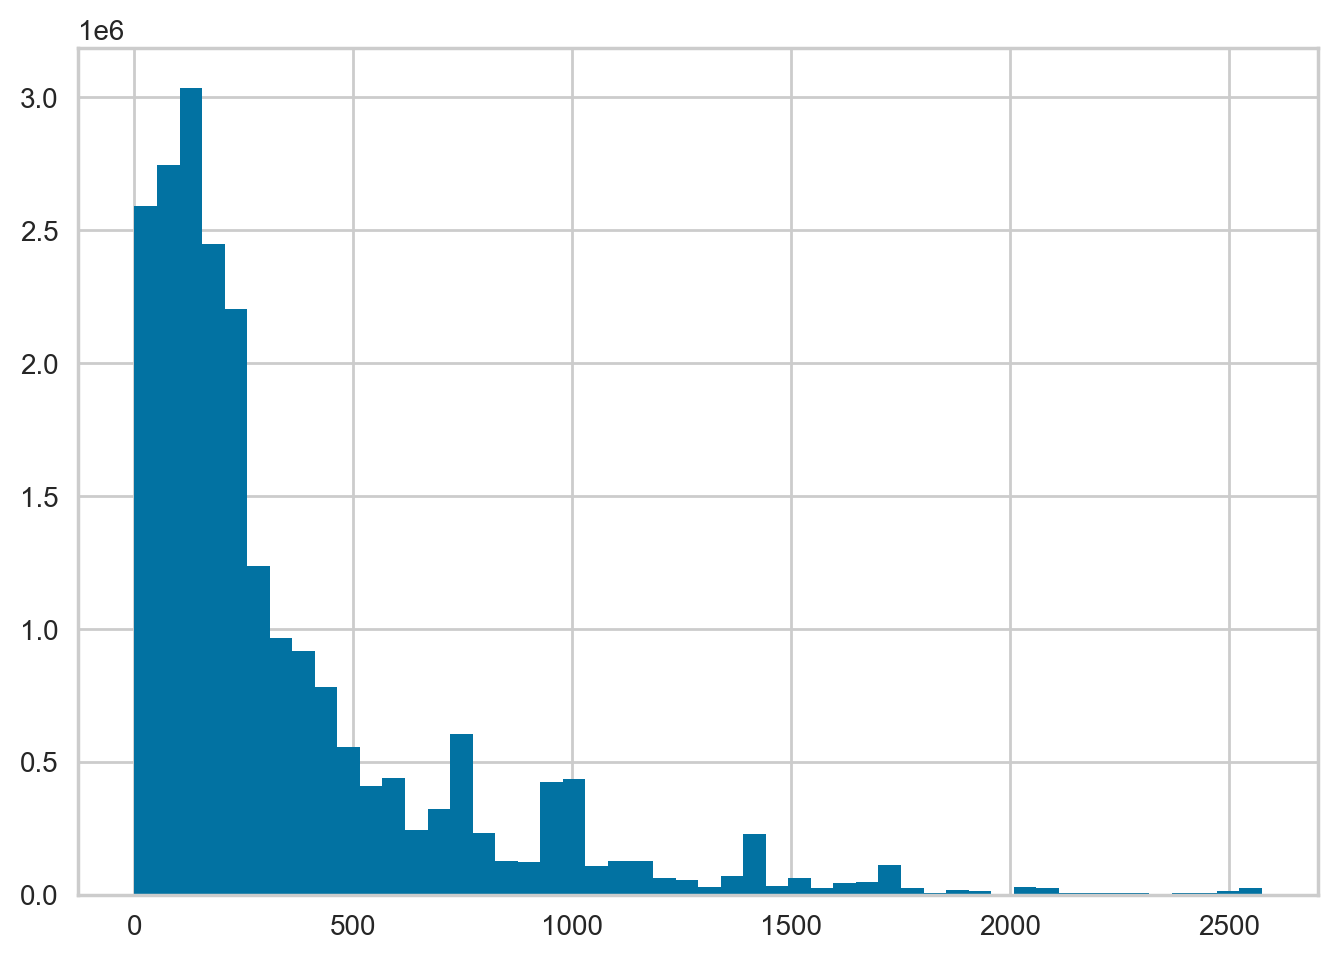

In [57]:
# price의 이상치 확인 1

df["price"].hist(bins=50)

<AxesSubplot:xlabel='price'>

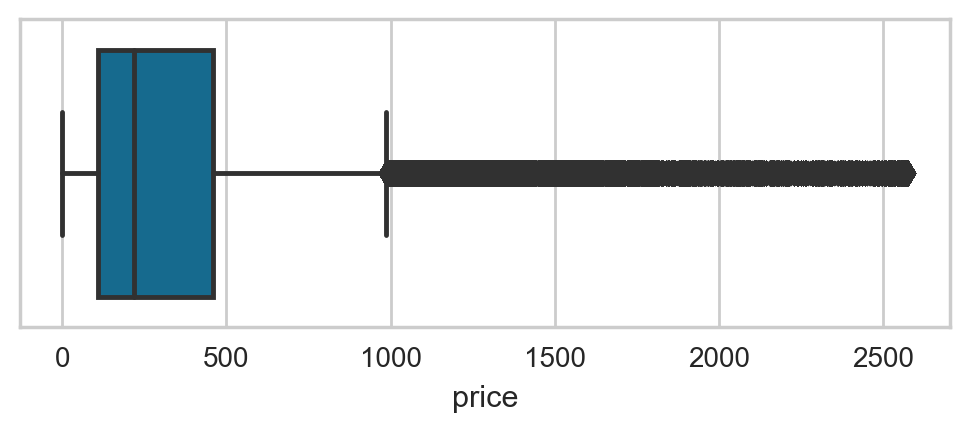

In [58]:
# price의 이상치 확인 2

plt.figure(figsize=(6,2))
sns.boxplot(data=df, x="price")

# 구매한 내역만 불러오기
- RFM 분석은 구매까지 진행한 고객을 대상으로 하는 분석이므로 구매고객만 추출

In [59]:
df_purchase = df[df["event_type"] == "purchase"].copy()
df_purchase

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id
7,2019-10-16 12:04:38+00:00,purchase,3601438,2053013563810775923,appliances.kitchen.washer,beko,203.410004,512935426
53,2019-10-16 12:04:39+00:00,purchase,1004750,2053013555631882655,electronics.smartphone,samsung,195.619995,560839537
84,2019-10-16 12:04:41+00:00,purchase,1004834,2053013555631882655,electronics.smartphone,samsung,173.389999,545171410
178,2019-10-16 12:04:46+00:00,purchase,1005105,2053013555631882655,electronics.smartphone,apple,1424.209961,514778102
193,2019-10-16 12:04:47+00:00,purchase,1801900,2053013554415534427,electronics.video.tv,samsung,483.459991,551965553
...,...,...,...,...,...,...,...,...
7074469,2019-10-11 17:54:34+00:00,purchase,1003235,2053013555631882655,electronics.smartphone,huawei,128.419998,559189082
7074484,2019-10-11 17:54:35+00:00,purchase,1005112,2053013555631882655,electronics.smartphone,apple,1003.849976,512404459
7074507,2019-10-11 17:54:35+00:00,purchase,1005115,2053013555631882655,electronics.smartphone,apple,1003.849976,540273893
7074511,2019-10-11 17:54:36+00:00,purchase,1002524,2053013555631882655,electronics.smartphone,apple,566.960022,533409964


#  RFM 계산
- 전체 주문에서 최근 주문일 구하기

In [60]:
last_timestamp = df_purchase["event_time"].max() + dt.timedelta(days=1)
df_purchase["event_time"].max(), last_timestamp

(Timestamp('2019-10-31 23:59:16+0000', tz='UTC'),
 Timestamp('2019-11-01 23:59:16+0000', tz='UTC'))

In [61]:
# Recency : 최근 거래 기준일(last_timestamp)과 고객별 최근 구매한 날짜(x.max())와 차이값
# Frequency : 구매 빈도수
# Monetary : 총 구매 금액

rfm = df_purchase.groupby("user_id").agg({"event_time": lambda x : (last_timestamp - x.max()).days,
                                  "product_id":"count",
                                  "price":"sum"})
rfm

,event_time,product_id,price
user_id,,,
384989212,14,1,41.439999
401021311,11,1,231.639999
403013066,14,2,807.160034
410333972,1,1,591.250000
415873351,1,2,263.059998
...,...,...,...
566265448,1,1,592.010010
566267483,1,2,30.740000
566270060,1,2,147.419998


In [62]:
# RFM 컬럼명 변경

rfm.columns = ["Recency", "Frequency", "MonetaryValue"]
rfm

,Recency,Frequency,MonetaryValue
user_id,,,
384989212,14,1,41.439999
401021311,11,1,231.639999
403013066,14,2,807.160034
410333972,1,1,591.250000
415873351,1,2,263.059998
...,...,...,...
566265448,1,1,592.010010
566267483,1,2,30.740000
566270060,1,2,147.419998


In [63]:
# R(최근 거래일 기준 고객별 최근 구매한 날짜와 차이값) 빈도수

rfm["Recency"].value_counts().sort_index()

1     10876
2      9902
3      9132
4      9114
5     10456
6      9930
7      9563
8      9567
9      9694
10     9547
11     9206
12     9216
13     9117
14     8980
15     9252
16     4253
21     8575
22     7431
23     7325
24     7158
25     6921
26     7832
27     7890
28     8853
29     6158
30     6199
31     6246
Name: Recency, dtype: int64

<AxesSubplot:xlabel='Recency', ylabel='count'>

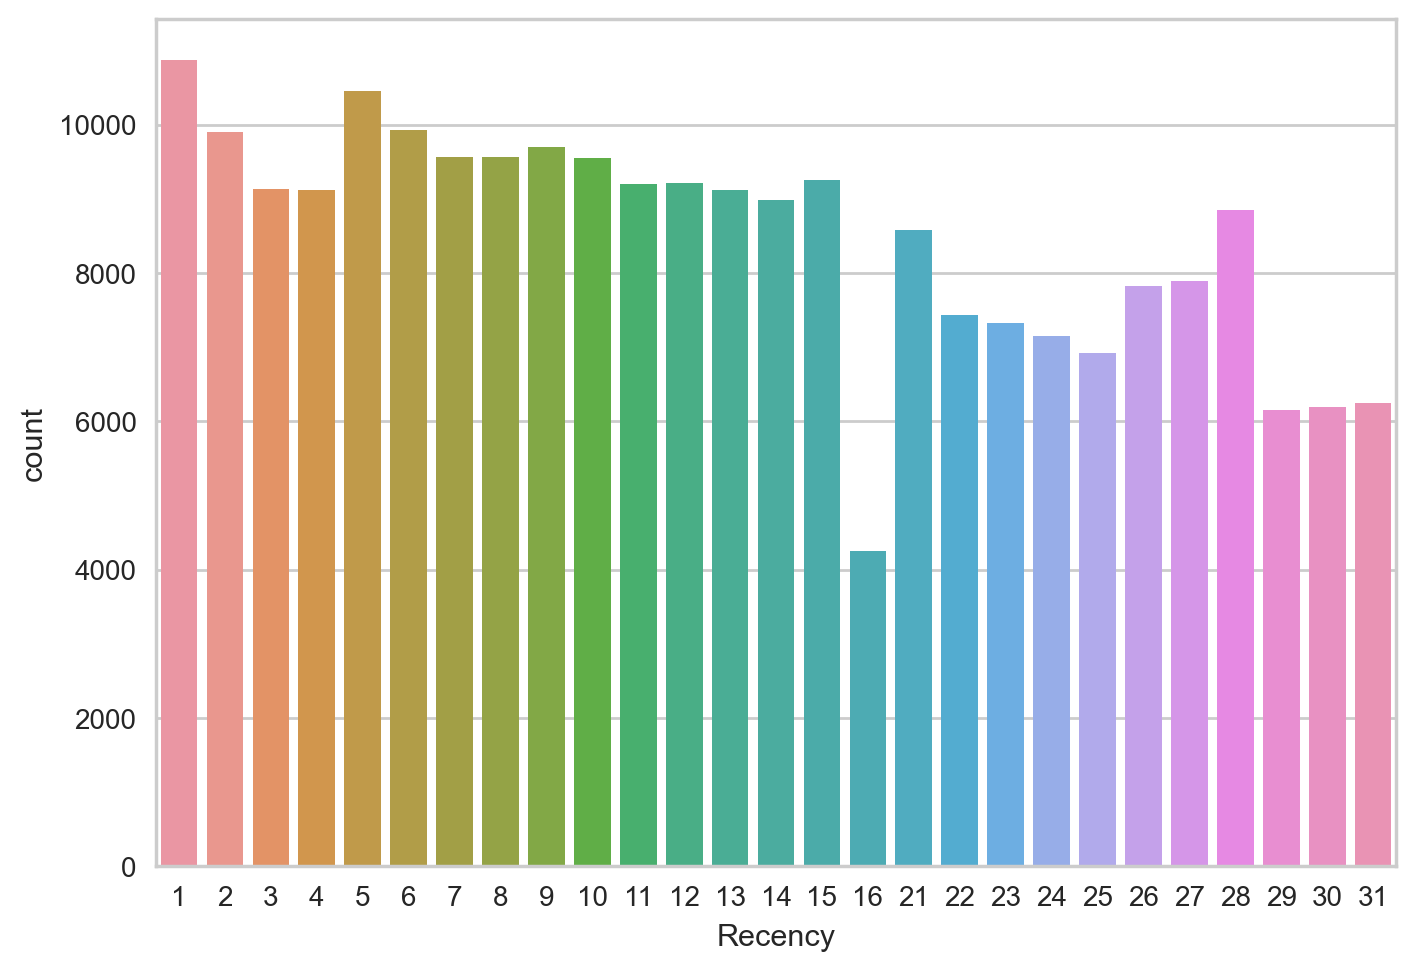

In [64]:
# R(최근 거래일 기준 고객별 최근 구매한 날짜와 차이값) 시각화
# 특이하게도 R값이 비교적 골고루 분포함

sns.countplot(data=rfm, x="Recency")

In [65]:
# 구매 횟수별 빈도수

rfm["Frequency"].value_counts().sort_index()

1      149260
2       40571
3       15575
4        7774
5        4267
        ...  
143         1
184         1
202         1
282         1
291         1
Name: Frequency, Length: 109, dtype: int64

<AxesSubplot:xlabel='Frequency', ylabel='count'>

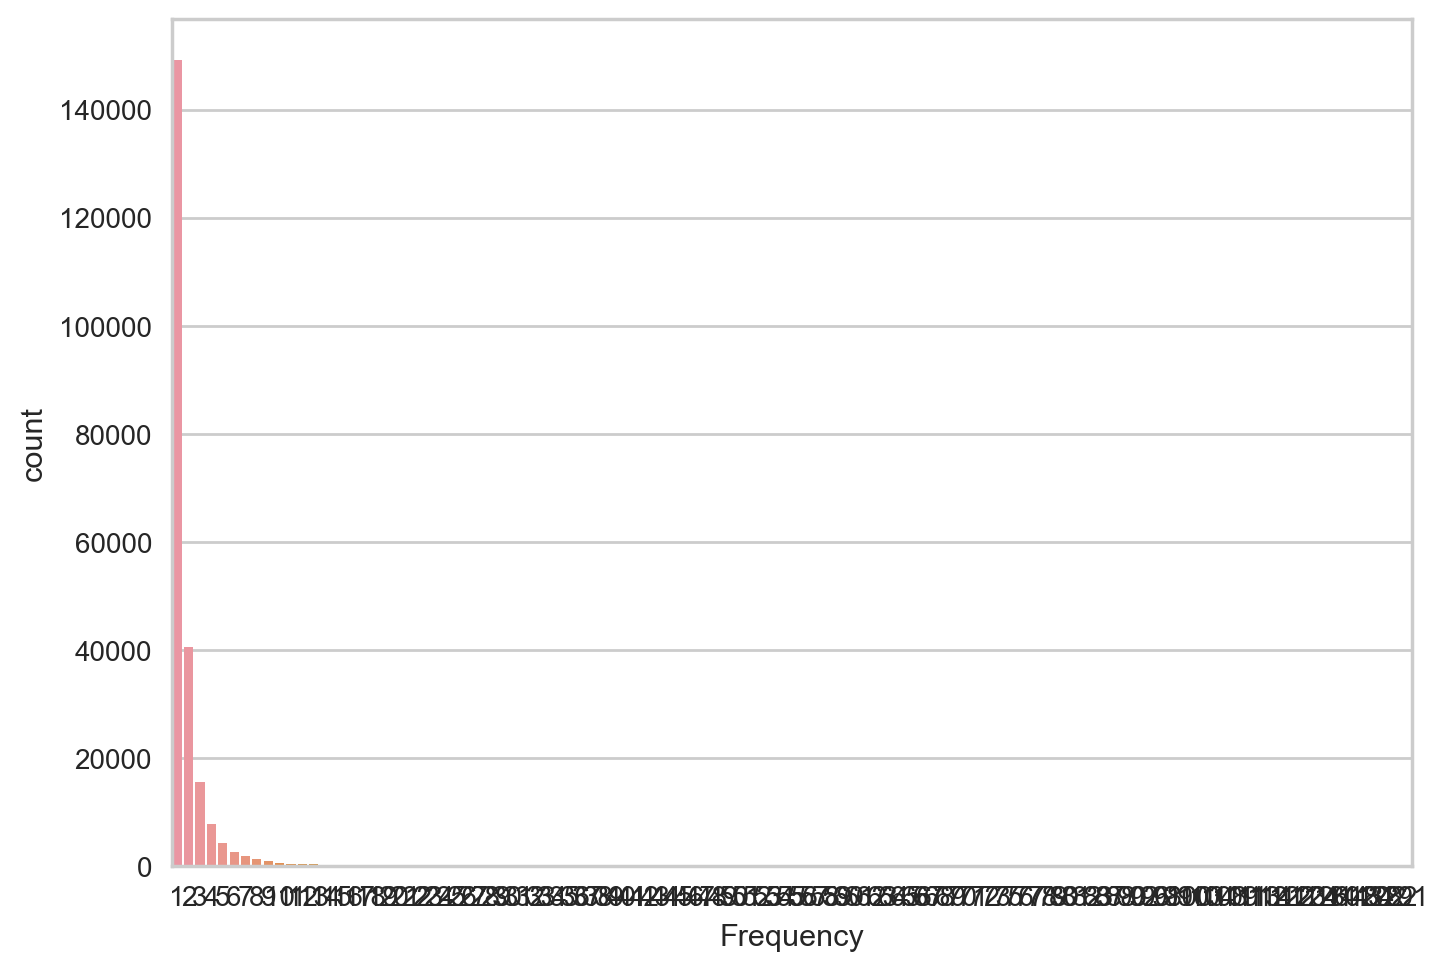

In [66]:
# 구매 횟수별 빈도수 시각화
# 1번 구매한 고객이 압도적으로 많음

sns.countplot(data=rfm, x="Frequency")

# RFM 모형
# qcut을 통해 RFM 변수 만들기

In [67]:
# Recency 는 최근일수록(값이 작을수록) 높은 점수
# Frequency, MonetaryValue 는 값이 클수록 높은 점수
r_labels = list(range(1, 6))[::-1]
f_labels = list(range(1, 6))
m_labels = list(range(1, 6))
cut_size = 5

In [68]:
r_cut = pd.qcut(rfm['Recency'].rank(method="first"), cut_size, r_labels)
f_cut = pd.qcut(rfm['Frequency'].rank(method="first"), cut_size, f_labels)
m_cut = pd.qcut(rfm['MonetaryValue'].rank(method="first"), cut_size, m_labels)


In [69]:
# R, F, M이라는 새로운 컬럼 생성

rfm = rfm.assign(R=r_cut, F=f_cut, M=m_cut)
rfm

,Recency,Frequency,MonetaryValue,R,F,M
user_id,,,,,,
384989212,14,1,41.439999,3,1,1
401021311,11,1,231.639999,3,1,3
403013066,14,2,807.160034,3,4,4
410333972,1,1,591.250000,5,1,4
415873351,1,2,263.059998,5,4,3
...,...,...,...,...,...,...
566265448,1,1,592.010010,5,4,4
566267483,1,2,30.740000,5,5,1
566270060,1,2,147.419998,5,5,2


In [70]:
# R, F, M 문자를 그대로 붙여 RFM Segment 만들기

rfm["RFM_segment"] = rfm["R"].astype(str) + rfm["F"].astype(str) + rfm["M"].astype(str)
rfm.head(1)

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment
user_id,,,,,,,
384989212,14,1,41.439999,3,1,1,311


In [71]:
# R, F, M 값의 합계로 Score 구하기
rfm["RFM_score"] = rfm[["R", "F", "M"]].sum(axis=1)
rfm.head(1)

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score
user_id,,,,,,,,
384989212,14,1,41.439999,3,1,1,311,5


<AxesSubplot:xlabel='RFM_segment', ylabel='RFM_score'>

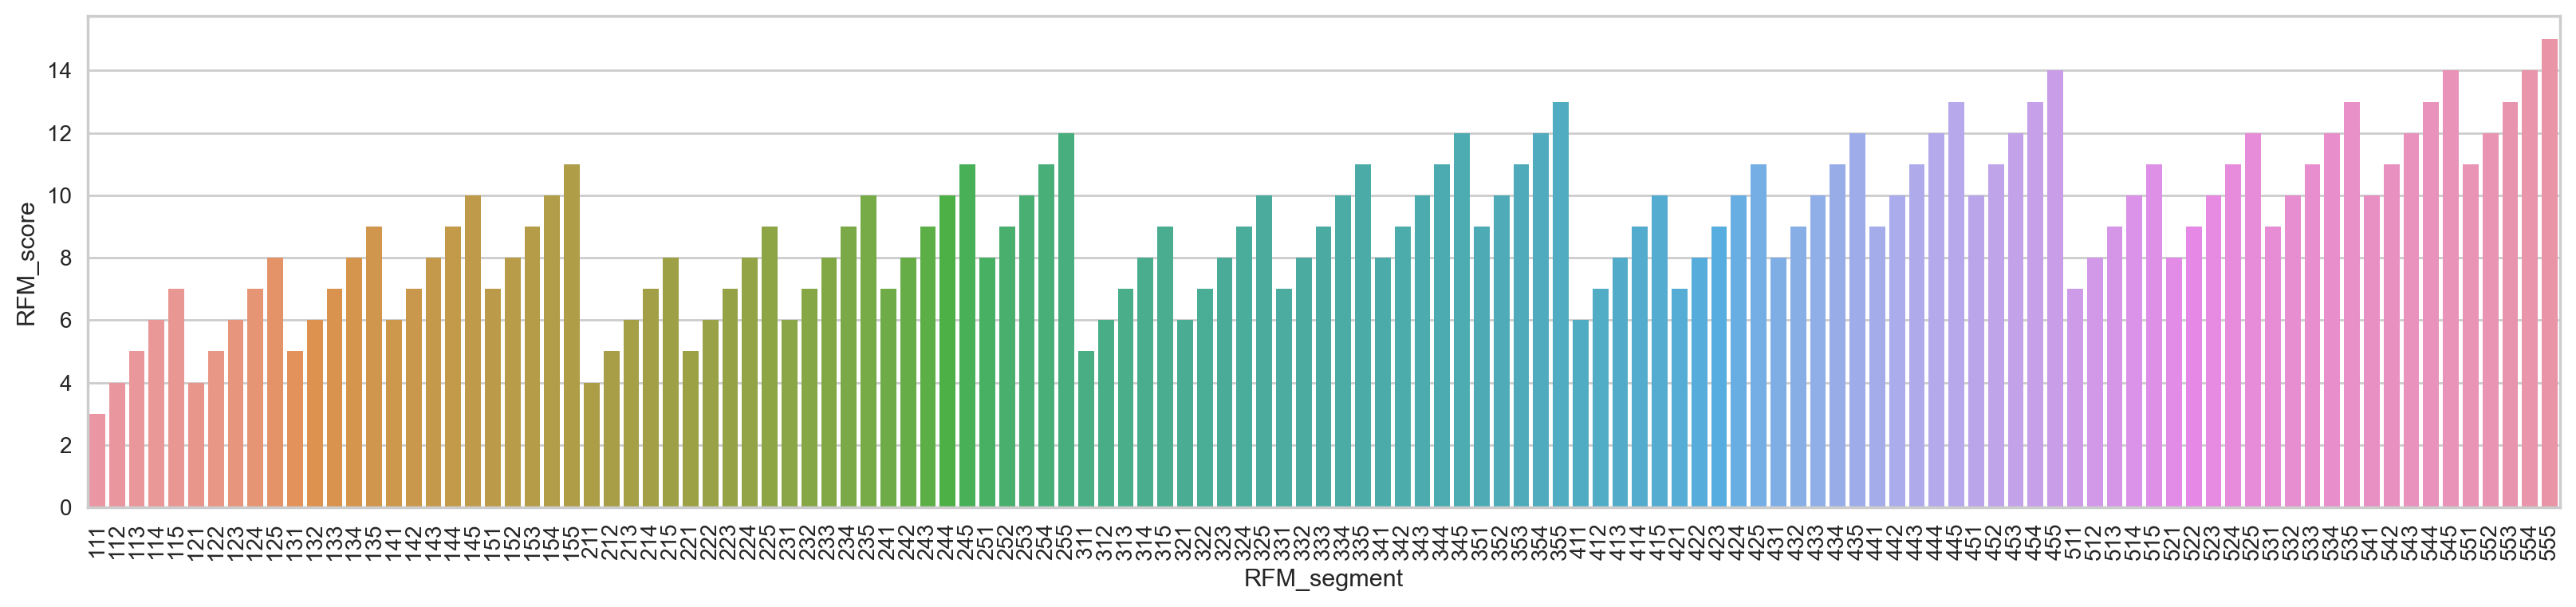

In [72]:
# RFM segment 값에 따라 RFM score 확인
plt.figure(figsize=(20, 4))
plt.xticks(rotation=90)
sns.barplot(data=rfm.sort_values("RFM_segment"), x="RFM_segment", y="RFM_score")

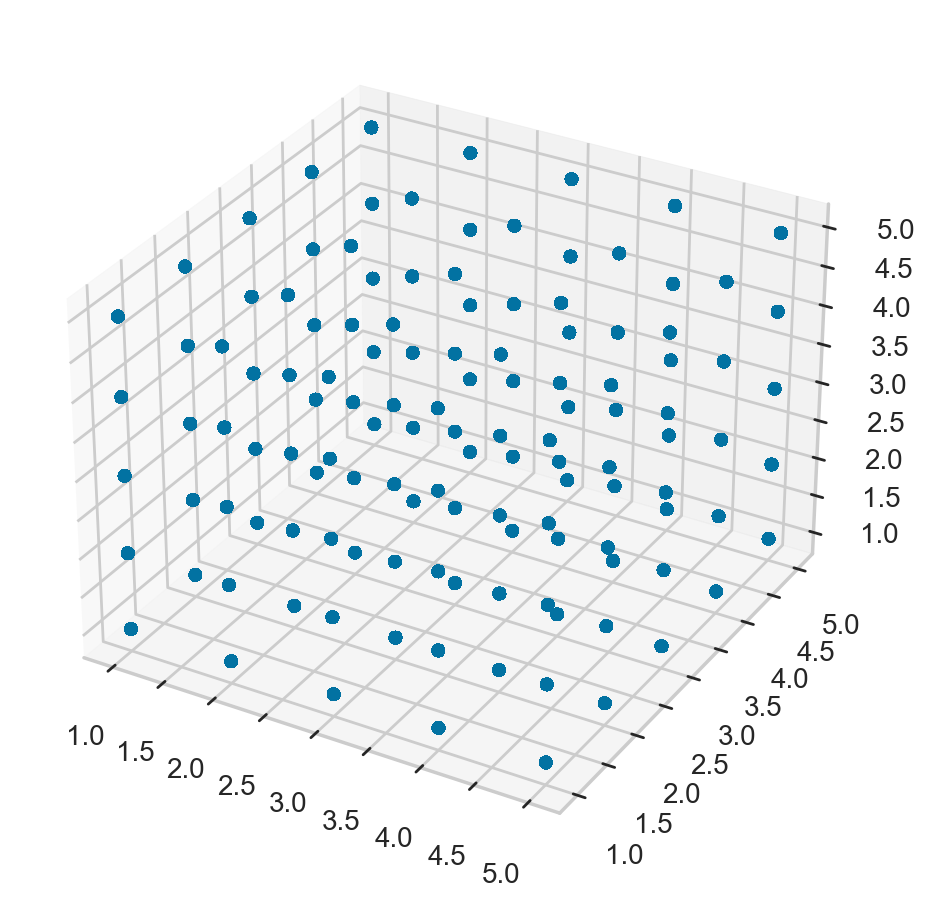

In [73]:
# 구간화가 잘 되었는지 3D로 확인
ax = plt.axes(projection='3d')
ax.scatter3D(rfm["R"], rfm["F"], rfm["M"])

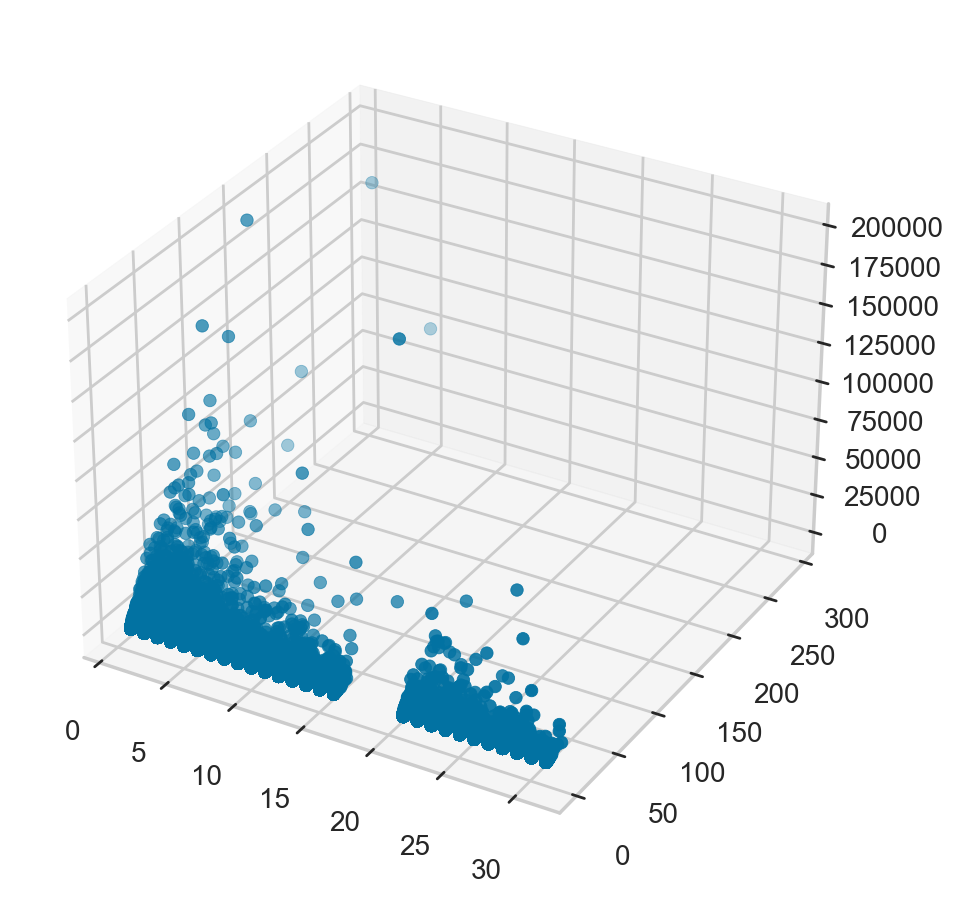

In [74]:
# 구간화 하지 않았을 때와 비교
ax = plt.axes(projection='3d')
ax.scatter3D(rfm["Recency"], rfm["Frequency"], rfm["MonetaryValue"])

In [75]:
# RFM score를 기준으로 Recency, Frequency, MonetaryValue 집계값 확인
# RFM score가 10, 11인 경우 MonetaryValue가 가장 높은 것을 확인 -> why? 단지 이 샘플 데이터셋에서만 그런걸수도..

rfm_g = rfm.groupby("RFM_score").agg({"Recency":"mean",
                                      "Frequency":"mean",
                                      "MonetaryValue":["mean", "sum"]
                                     }).style.background_gradient().format("{:,.0f}")
rfm_g

# silver, gold, platinum으로 고객군 나누기

In [76]:
# qcut 을 통해 3단계로 "silver", "gold", "platinum" 고객군을 나눕니다. 

labels = ["silver", "gold", "platinum"]
rfm["RFM_class"] = pd.qcut(rfm["RFM_score"], 3, labels)
rfm.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score,RFM_class
user_id,,,,,,,,,
384989212,14,1,41.439999,3,1,1,311,5,silver
401021311,11,1,231.639999,3,1,3,313,7,silver
403013066,14,2,807.160034,3,4,4,344,11,platinum
410333972,1,1,591.250000,5,1,4,514,10,gold
415873351,1,2,263.059998,5,4,3,543,12,platinum


In [77]:
# RFM_score에 따라 RFM_class 값이 잘 나뉘었는지 확인. min-max 확인.
# gold보다 platinum이 더 많음.

rfm.groupby("RFM_class")["RFM_score"].describe()

,count,mean,std,min,25%,50%,75%,max
RFM_class,,,,,,,,
silver,80296.0,5.791359,1.155453,3.0,5.0,6.0,7.0,7.0
gold,75516.0,8.937735,0.816090,8.0,8.0,9.0,10.0,10.0
platinum,72581.0,12.614486,1.371641,11.0,11.0,12.0,14.0,15.0


<AxesSubplot:xlabel='RFM_class', ylabel='RFM_score'>

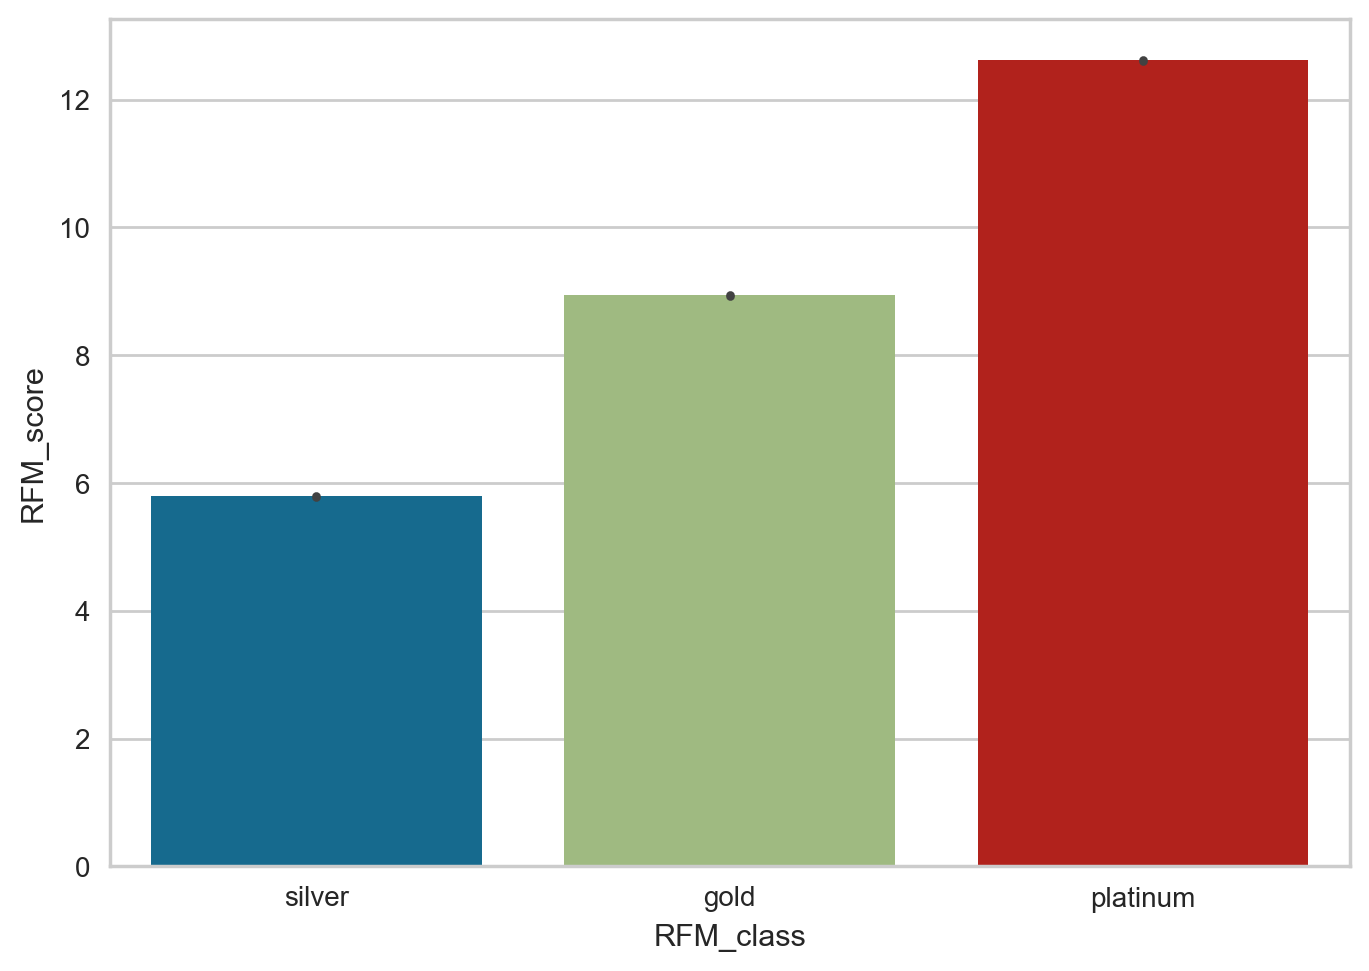

In [78]:
# RFM_class 별 평균 RFM_score 확인(default : 평균)
# barplot

sns.barplot(data=rfm, x="RFM_class", y="RFM_score")

<AxesSubplot:xlabel='RFM_class', ylabel='RFM_score'>

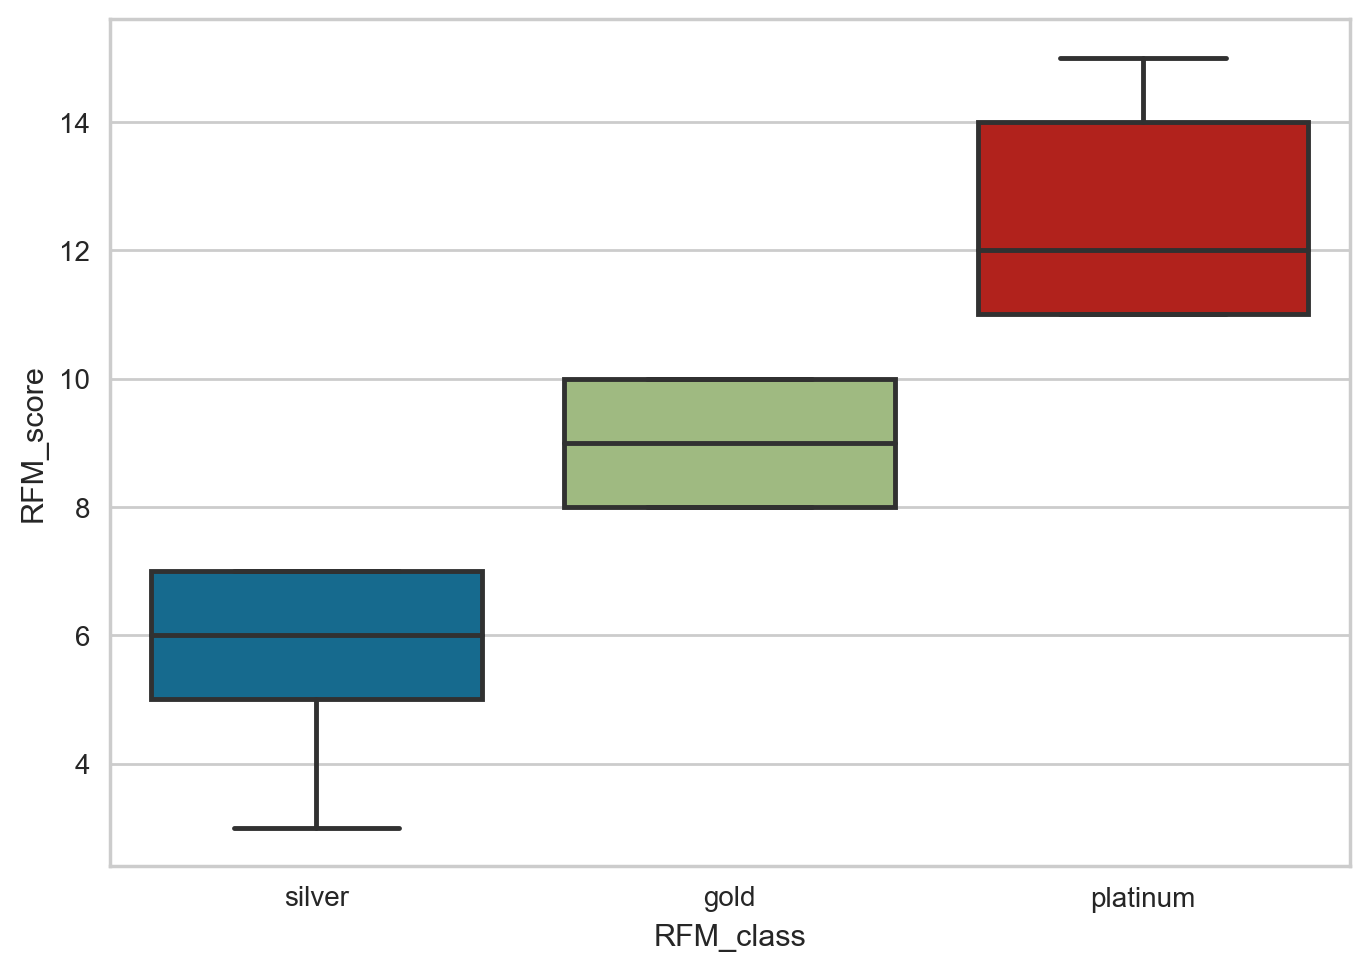

In [79]:
# 같은 내용을 boxplot으로 확인

sns.boxplot(data=rfm, x="RFM_class", y="RFM_score")

<AxesSubplot:xlabel='R', ylabel='RFM_score'>

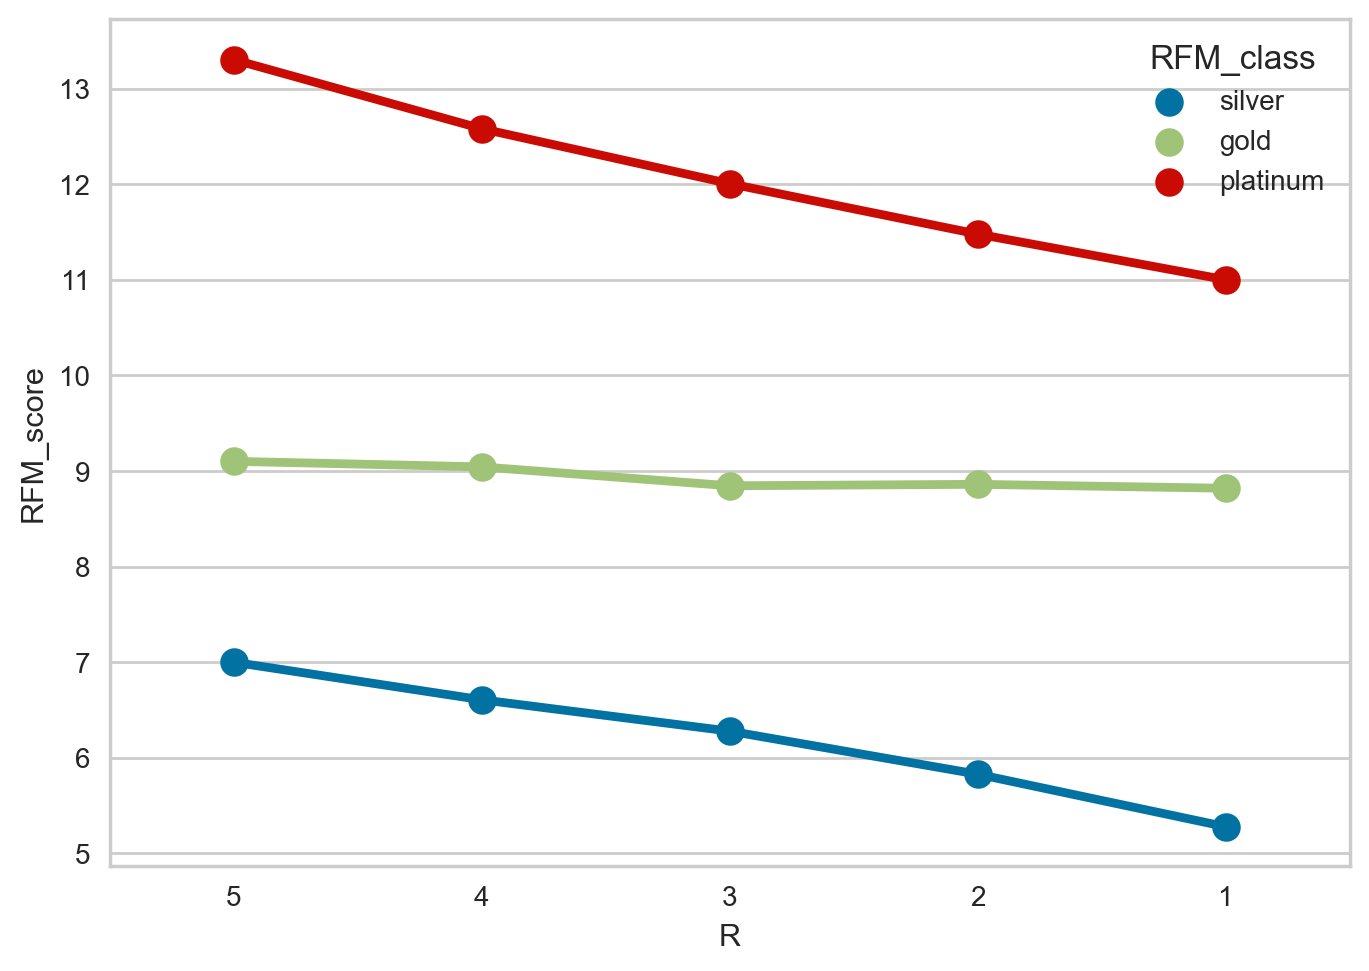

In [80]:
# R을 기준으로 RFM_class가 잘 나뉘어졌는지 확인

sns.pointplot(data=rfm, x="R", y="RFM_score", hue="RFM_class")

In [81]:
# "RFM_class"를 기준으로 Recency, Frequency, MonetaryValue 확인

rfm_class_g = rfm.groupby("RFM_class").agg({"Recency":"mean",
                                            "Frequency":"mean",
                                            "MonetaryValue":["mean", "sum", "count"]})
rfm_class_g.style.background_gradient().format("{:,.2f}")

In [82]:
# RFM 분석 자료를 parquet으로 저장
rfm.to_parquet("mini_rfm.gzip", compression="gzip")

In [83]:
# /content/mini_rfm.gzip

In [103]:
rfm=pd.read_parquet('mini_rfm.gzip')
rfm

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score,RFM_class
user_id,,,,,,,,,
384989212,14,1,41.439999,3,1,1,311,5,silver
401021311,11,1,231.639999,3,1,3,313,7,silver
403013066,14,2,807.160034,3,4,4,344,11,platinum
410333972,1,1,591.250000,5,1,4,514,10,gold
415873351,1,2,263.059998,5,4,3,543,12,platinum
...,...,...,...,...,...,...,...,...,...
566265448,1,1,592.010010,5,4,4,544,13,platinum
566267483,1,2,30.740000,5,5,1,551,11,platinum
566270060,1,2,147.419998,5,5,2,552,12,platinum


# 클러스터링

In [104]:
rfm_cluster = rfm.iloc[:, :3]
print(rfm_cluster.shape)
rfm_cluster.head(2)


(228393, 3)


,Recency,Frequency,MonetaryValue
user_id,,,
384989212,14,1,41.439999
401021311,11,1,231.639999


In [105]:
# MonetaryValue에 이상치가 있음. mean과 50%확인

rfm_cluster.describe()

,Recency,Frequency,MonetaryValue
count,228393.000000,228393.000000,228393.000000
mean,14.339691,1.986742,737.289917
std,9.384898,3.243977,2003.170410
min,1.000000,1.000000,0.880000
25%,6.000000,1.000000,143.119995
50%,12.000000,1.000000,285.720001
75%,24.000000,2.000000,730.260010
max,31.000000,291.000000,198916.640625


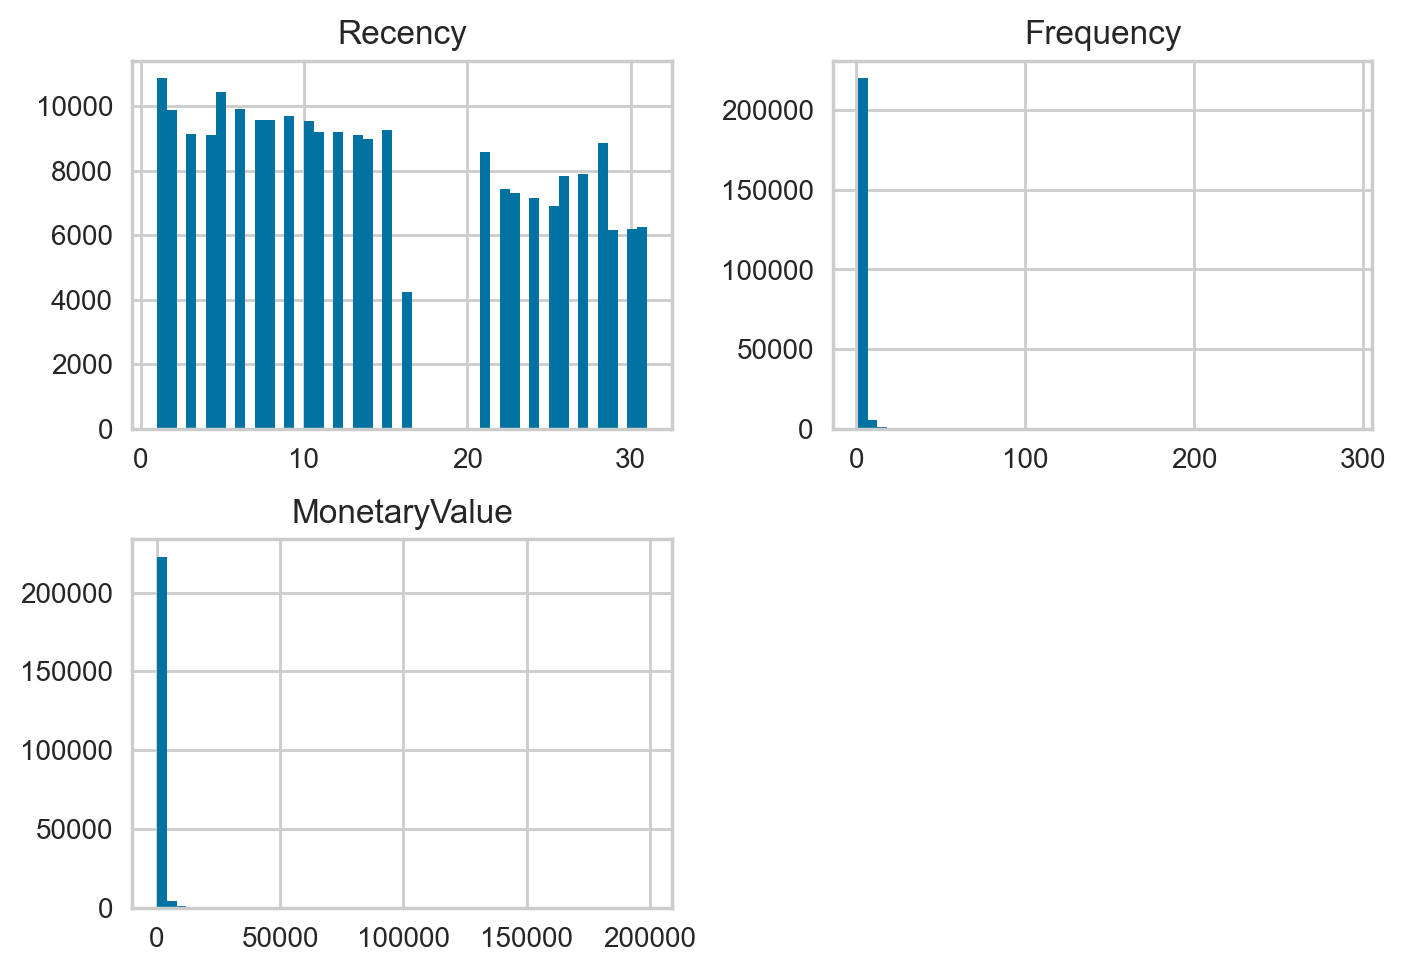

In [106]:
# 한쪽으로 치우친 데이터
# 정규분포로 만들어야 함 -> log 활용

rfm_cluster.hist(bins=50);

In [107]:
# rfm_cluster log 변환

rfm_cluster_log = np.log(rfm_cluster + 1)
rfm_cluster_log.head(2)

,Recency,Frequency,MonetaryValue
user_id,,,
384989212,2.708050,0.693147,3.748091
401021311,2.484907,0.693147,5.449492


# 스케일 조정

In [108]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler() # 스케일러
ss.fit(rfm_cluster_log) # 평균과 표준편차 학습
X = ss.transform(rfm_cluster_log) # 평균을 0, 표준편차를 1로 변환
X

array([[ 0.29132083, -0.56946415, -1.62675977],
       [ 0.00310372, -0.56946415, -0.2550502 ],
       [ 0.29132083,  0.34975059,  0.74891462],
       ...,
       [-2.31117221,  0.34975059, -0.61740398],
       [-2.31117221, -0.56946415,  1.48454329],
       [-2.31117221, -0.56946415,  1.33025895]])

In [109]:
pd.DataFrame(X).describe().round(2)

,0,1,2
count,228393.00,228393.00,228393.00
mean,-0.00,-0.00,0.00
std,1.00,1.00,1.00
min,-2.31,-0.57,-4.14
25%,-0.69,-0.57,-0.64
50%,0.11,-0.57,-0.09
75%,0.95,0.35,0.67
max,1.27,10.73,5.19


# K-means

In [101]:
# K-means를 활용해 적절한 군집의 개수 파악하기

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)
kmeans.cluster_centers_, kmeans.inertia_

inertia = [] # 각 군집별 오차의 제곱의 합
silhouettes = []
range_n_clusters = range(2, 20) # 클러스터의 개수 (2개~19개 중 적절한 클러스터의 개수가 뭘까?)

for n_cluster in range_n_clusters:
    kmeans = KMeans(n_clusters=n_cluster, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X, labels=kmeans.labels_))
    print(n_cluster, end=",")

/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


2,

/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


3,

/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


4,

/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KeyboardInterrupt: 

# Elbow Method
 - 최적의 군집의 개수는 몇개일까?

/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/clust

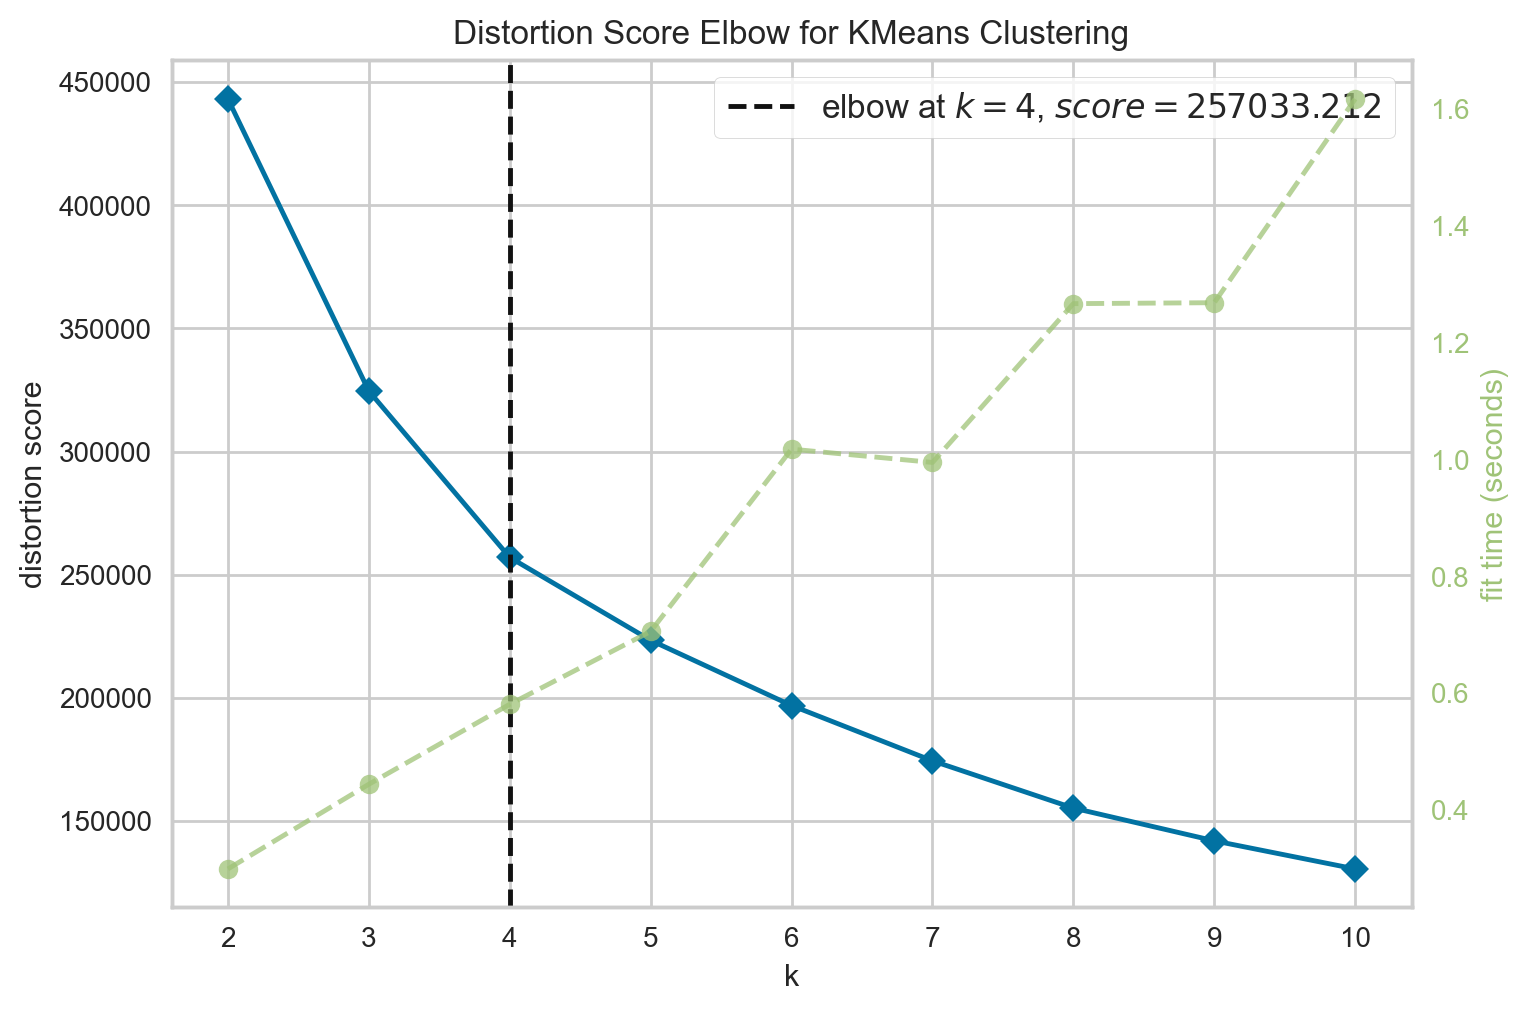

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [92]:
from yellowbrick.cluster import KElbowVisualizer

kev = KElbowVisualizer(kmeans, k=10)
kev.fit(X)
kev.show()

In [110]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=4, random_state=42)

In [111]:
pd.Series(kmeans.labels_).value_counts()

1    82882
3    66557
0    55713
2    23241
dtype: int64

In [97]:
# silhouette_score 구하기

silhouette_avg = silhouette_score(X, kmeans.labels_)


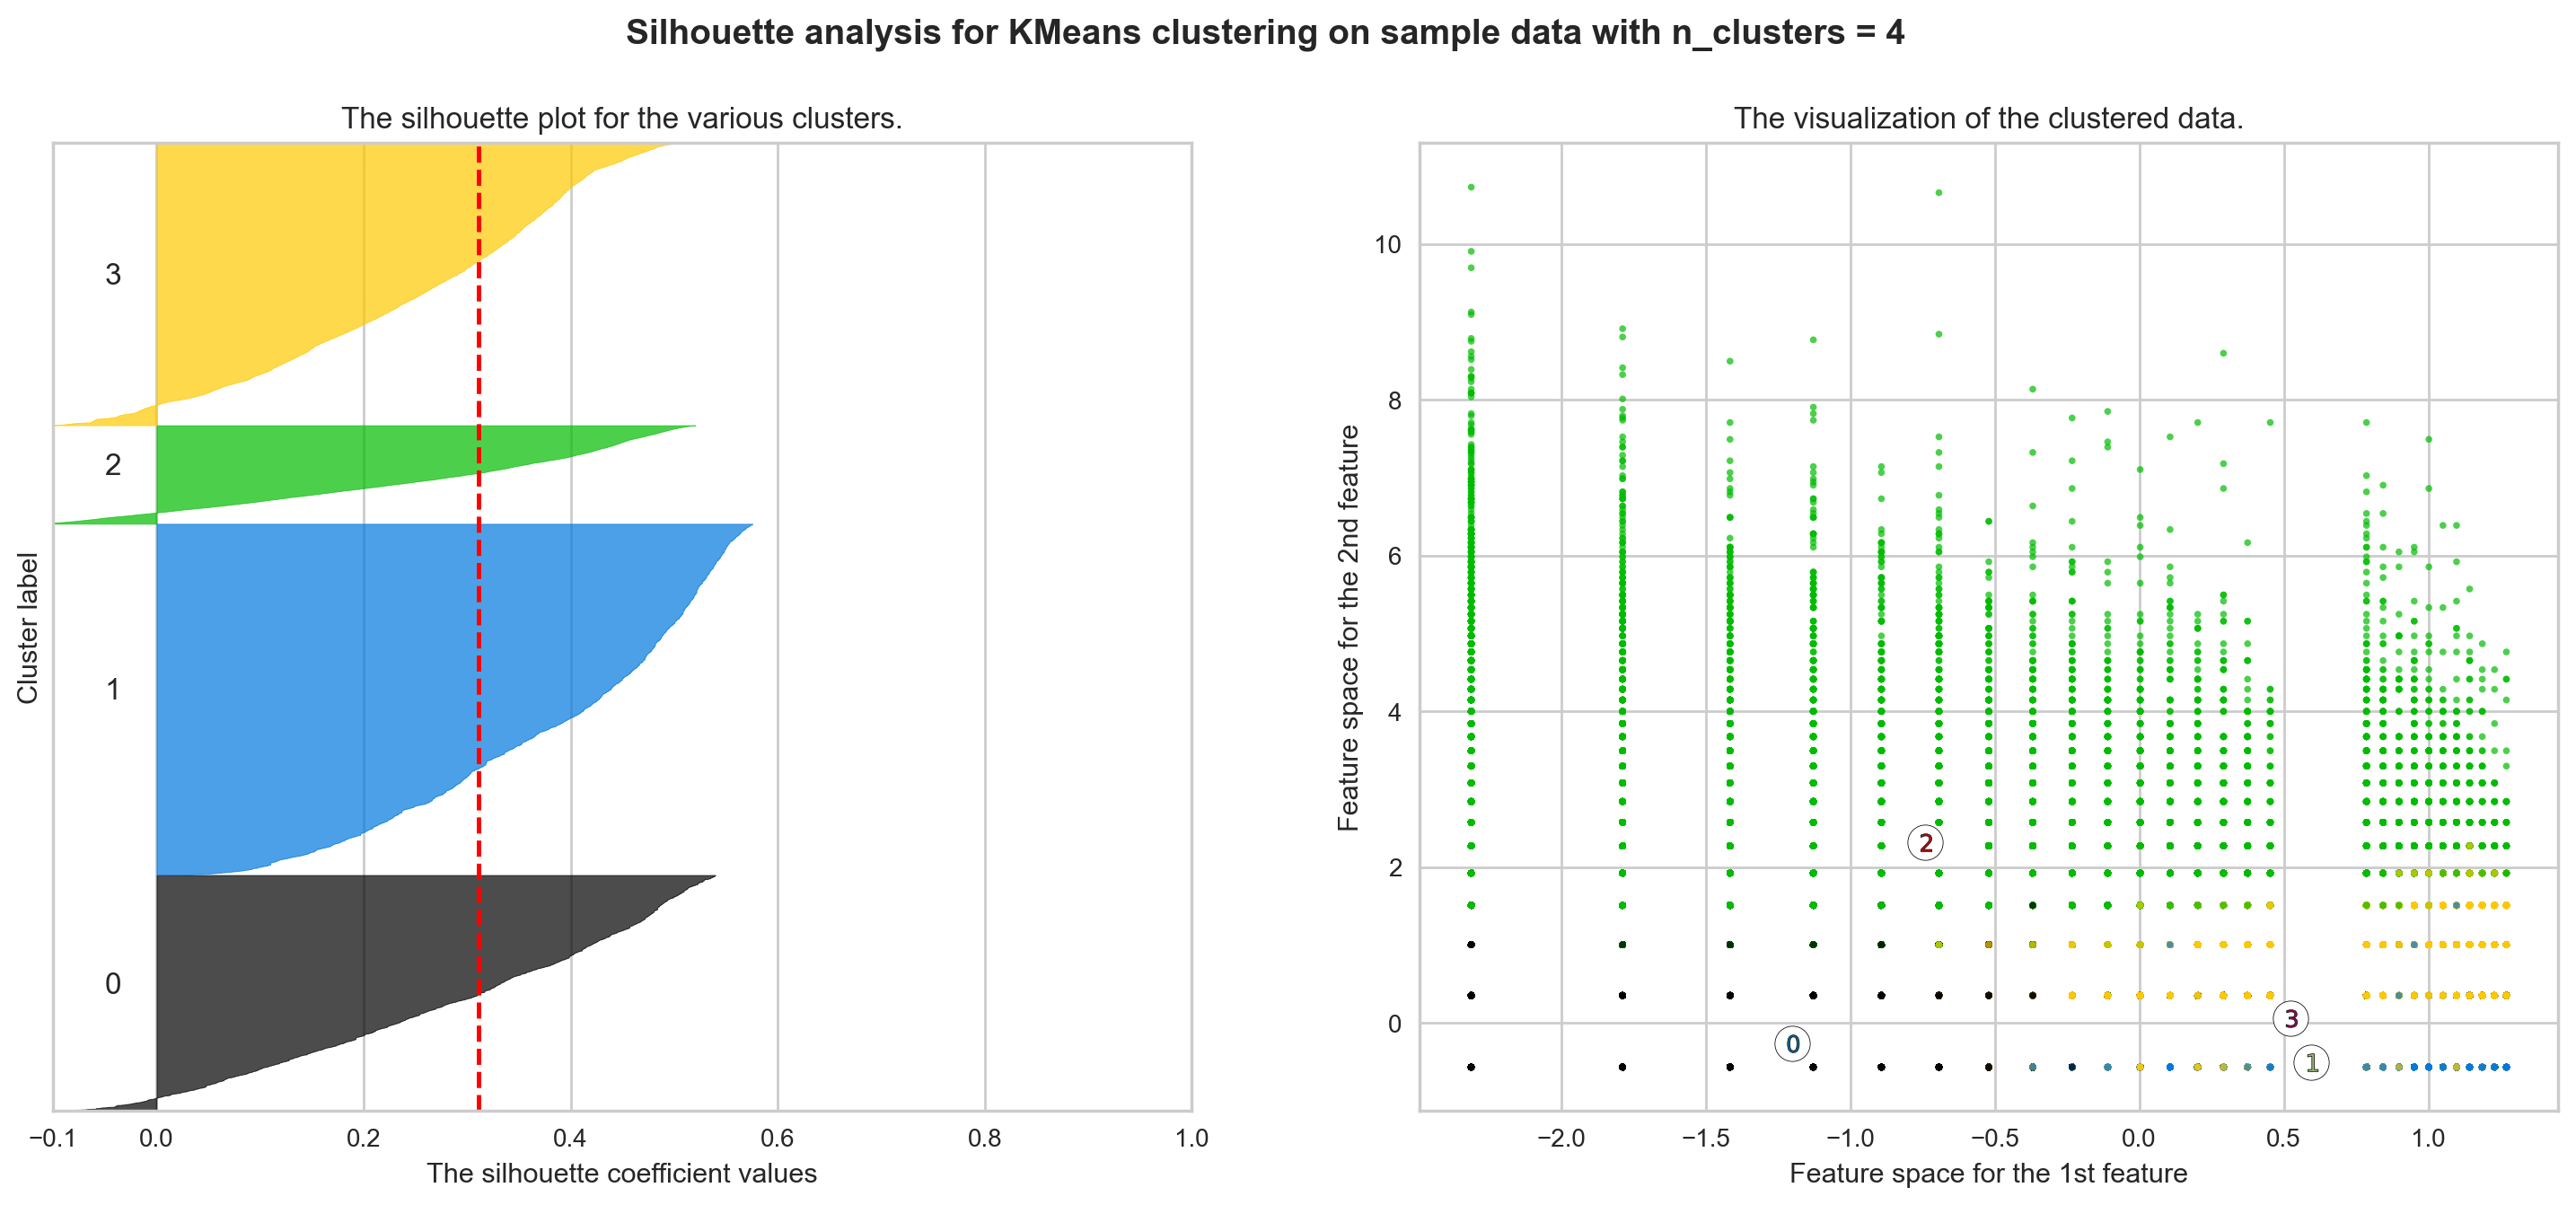

In [98]:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm

# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    
cluster_labels = kmeans.labels_
sample_silhouette_values = silhouette_samples(X, cluster_labels)

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
ax2.scatter(
    X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
)

# Labeling the clusters
centers = kmeans.cluster_centers_
# Draw white circles at cluster centers
ax2.scatter(
    centers[:, 0],
    centers[:, 1],
    marker="o",
    c="white",
    alpha=1,
    s=200,
    edgecolor="k",
)

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

ax2.set_title("The visualization of the clustered data.")
ax2.set_xlabel("Feature space for the 1st feature")
ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(
    "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
    % n_clusters,
    fontsize=14,
    fontweight="bold",
)

plt.show()

In [113]:
rfm["Cluster"] = kmeans.labels_
rfm.head(2)

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score,RFM_class,Cluster
user_id,,,,,,,,,,
384989212,14,1,41.439999,3,1,1,311,5,silver,1
401021311,11,1,231.639999,3,1,3,313,7,silver,1


In [114]:
pd.crosstab(rfm["RFM_class"], rfm["Cluster"])

Cluster,0,1,2,3
RFM_class,,,,
silver,4702,66581,2,9011
gold,25345,16292,105,33774
platinum,25666,9,23134,23772


# 0번 집단

In [119]:
clu0 = rfm[rfm['Cluster'] == 0]
clu0

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score,RFM_class,Cluster
user_id,,,,,,,,,,
410333972,1,1,591.250000,5,1,4,514,10,gold,0
415873351,1,2,263.059998,5,4,3,543,12,platinum,0
418115333,4,1,127.419998,5,1,1,511,7,silver,0
430524990,3,1,130.990005,5,1,1,511,7,silver,0
431897261,4,1,463.329987,5,1,4,514,10,gold,0
...,...,...,...,...,...,...,...,...,...,...
566265448,1,1,592.010010,5,4,4,544,13,platinum,0
566267483,1,2,30.740000,5,5,1,551,11,platinum,0
566270060,1,2,147.419998,5,5,2,552,12,platinum,0


<AxesSubplot:>

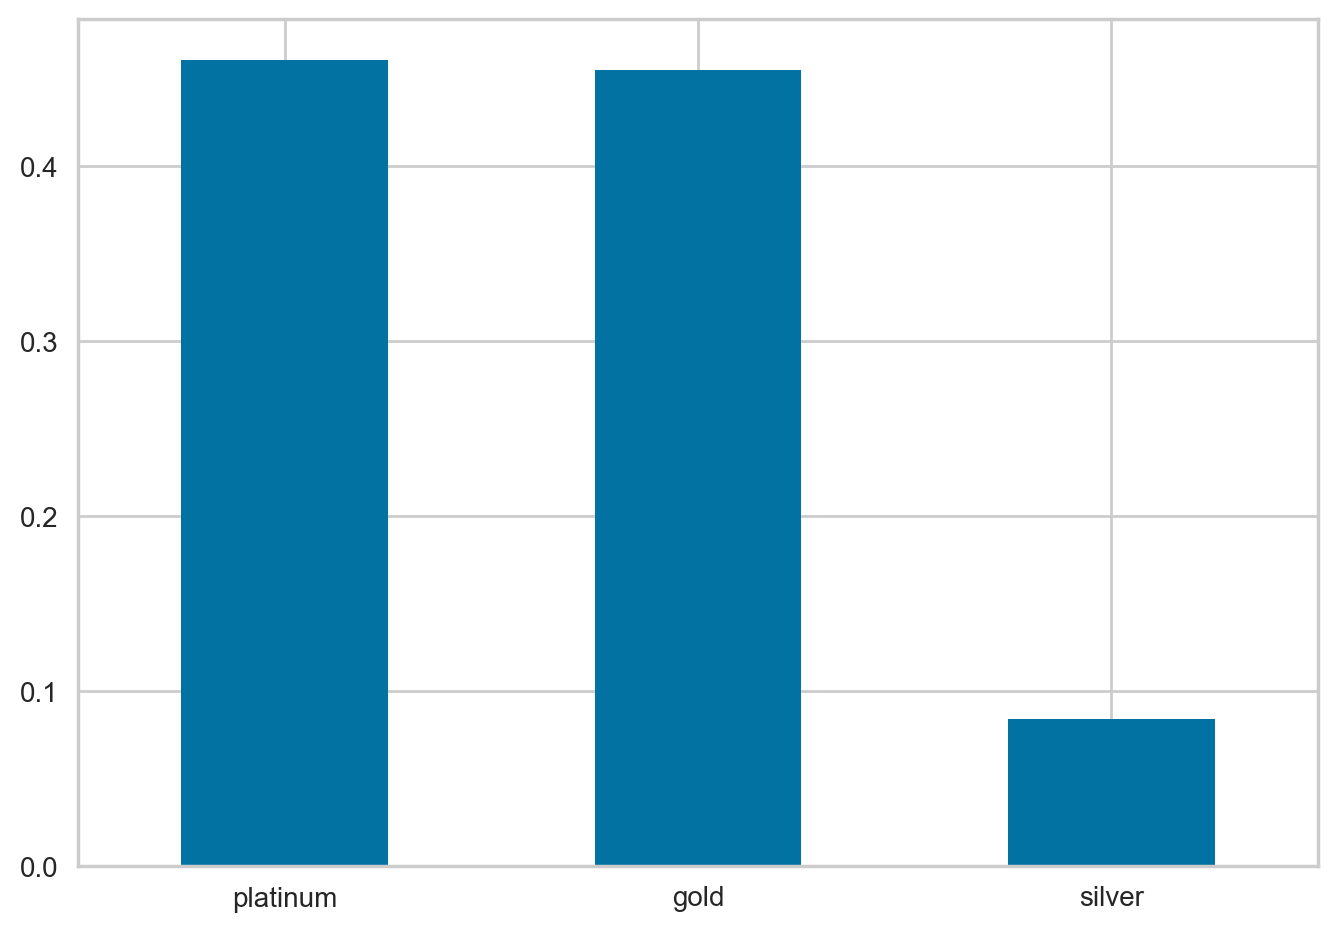

In [123]:
clu0['RFM_class'].value_counts(1).plot.bar(rot=0) 

In [118]:
clu1 = rfm[rfm['Cluster'] == 1]
clu1

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score,RFM_class,Cluster
user_id,,,,,,,,,,
384989212,14,1,41.439999,3,1,1,311,5,silver,1
401021311,11,1,231.639999,3,1,3,313,7,silver,1
424869855,8,1,88.290001,4,1,1,411,6,silver,1
431246706,9,1,170.830002,4,1,2,412,7,silver,1
433754231,30,1,321.730011,1,1,3,113,5,silver,1
...,...,...,...,...,...,...,...,...,...,...
564800747,5,1,12.840000,4,4,1,441,9,gold,1
564853008,4,1,8.730000,5,4,1,541,10,gold,1
564928973,4,1,7.930000,5,4,1,541,10,gold,1


<AxesSubplot:>

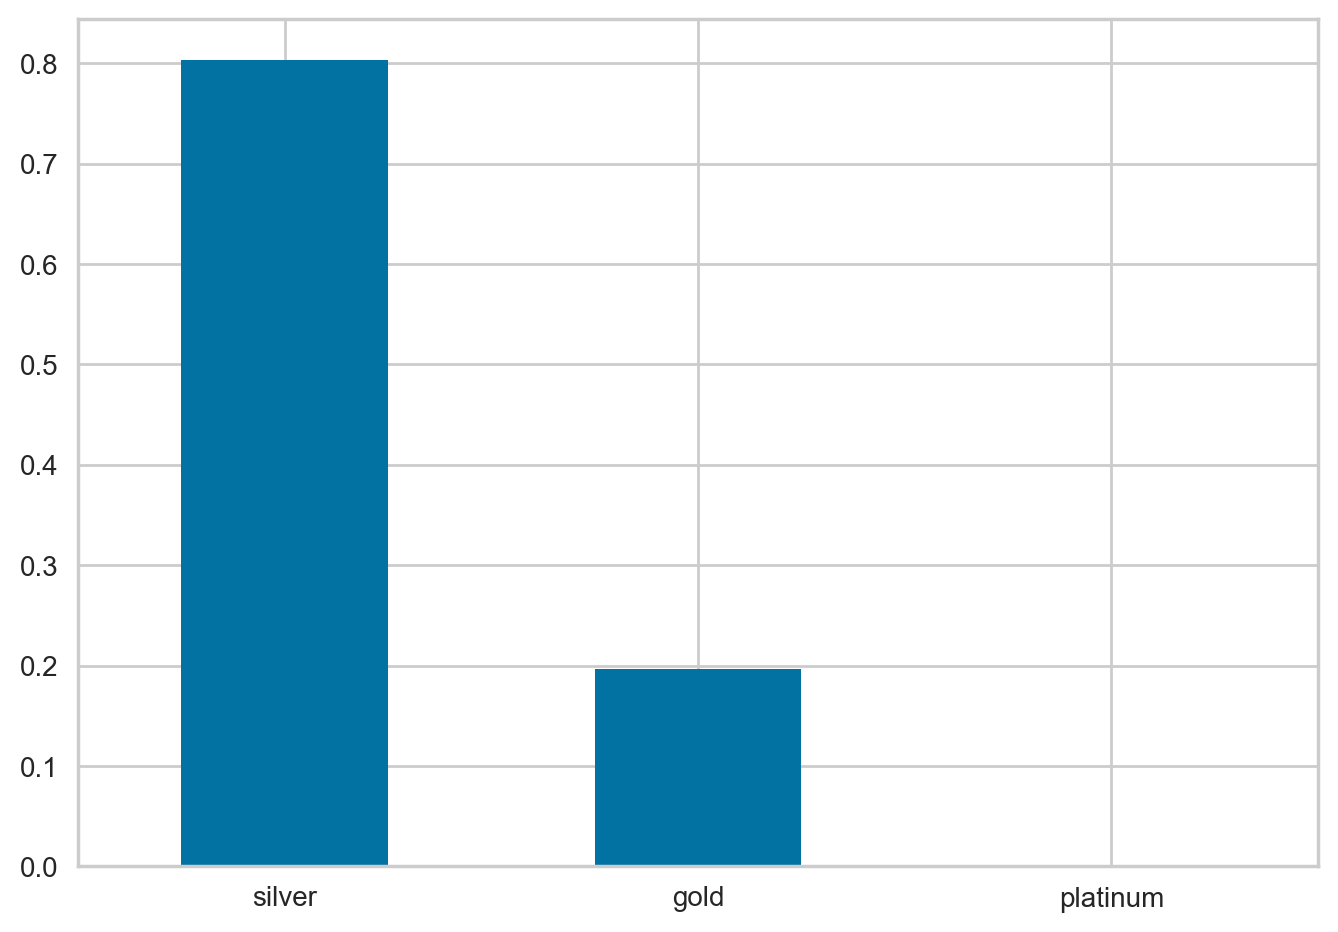

In [124]:
clu1['RFM_class'].value_counts(1).plot.bar(rot=0) # 1번 클러스터에는 silver 고객이 많음

In [120]:
clu2 = rfm[rfm['Cluster'] == 2]
clu2

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score,RFM_class,Cluster
user_id,,,,,,,,,,
475786534,23,6,1551.590088,2,5,5,255,12,platinum,2
489085769,11,8,897.750000,3,5,4,354,12,platinum,2
492103460,24,6,2157.790039,2,5,5,255,12,platinum,2
493690536,11,4,1095.280029,3,5,5,355,13,platinum,2
497226076,2,14,10488.480469,5,5,5,555,15,platinum,2
...,...,...,...,...,...,...,...,...,...,...
566209184,1,3,1597.709961,5,5,5,555,15,platinum,2
566213717,1,3,2167.200195,5,5,5,555,15,platinum,2
566215463,1,4,1725.520020,5,5,5,555,15,platinum,2


<AxesSubplot:>

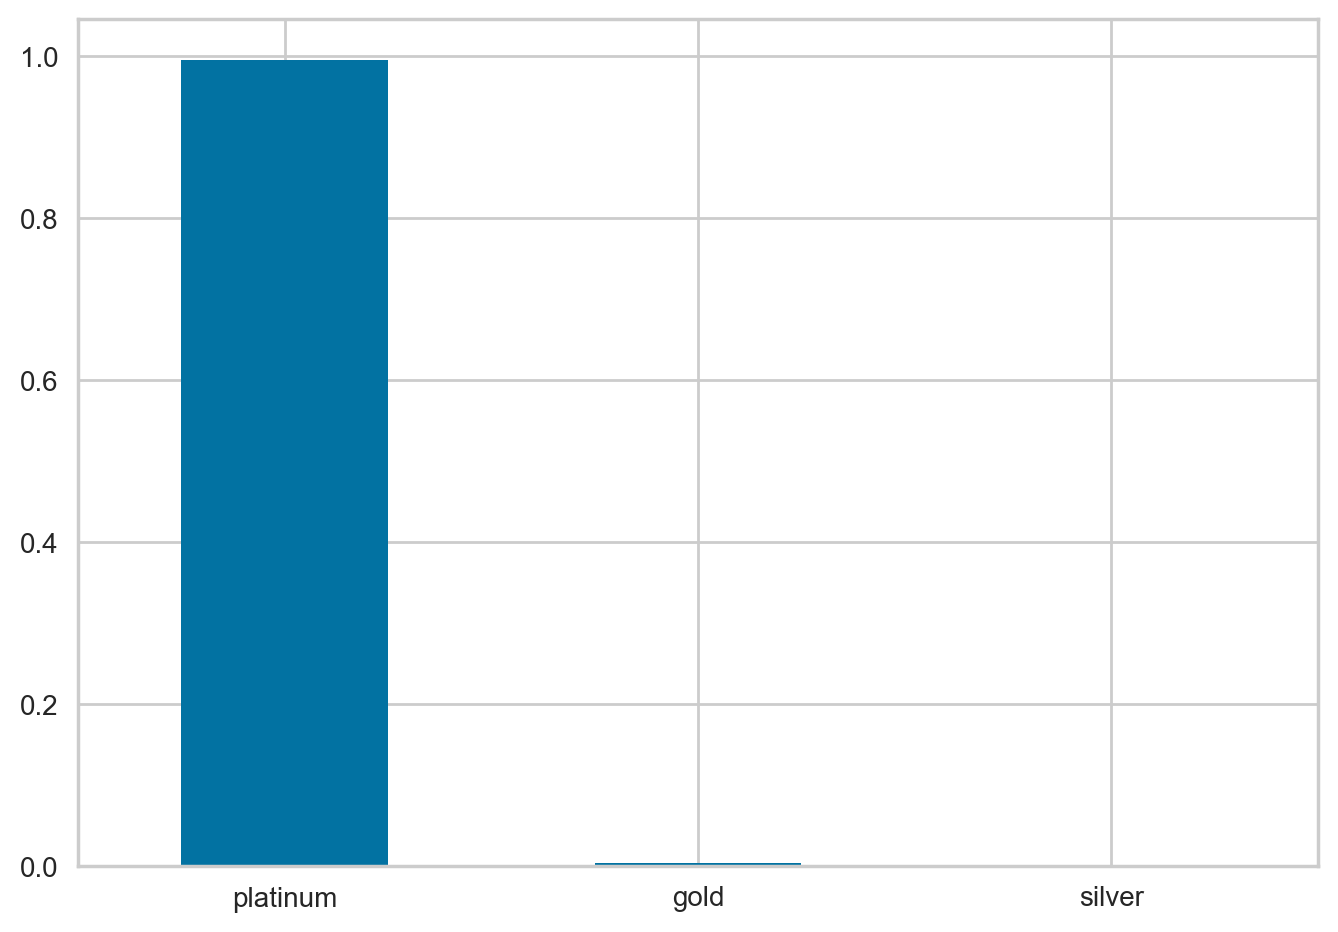

In [125]:
clu2['RFM_class'].value_counts(1).plot.bar(rot=0) # 2번 클러스터에는 platinum 고객이 많음

In [121]:
clu3 = rfm[rfm['Cluster'] == 3]
clu3

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score,RFM_class,Cluster
user_id,,,,,,,,,,
403013066,14,2,807.160034,3,4,4,344,11,platinum,3
420935067,25,1,385.839996,2,1,3,213,6,silver,3
435648894,26,1,388.130005,1,1,3,113,5,silver,3
435786120,14,1,437.850006,3,1,4,314,8,gold,3
437371552,30,2,358.289978,1,4,3,143,8,gold,3
...,...,...,...,...,...,...,...,...,...,...
564751628,5,2,1625.109863,4,5,5,455,14,platinum,3
564759853,5,2,3326.979980,4,5,5,455,14,platinum,3
564791602,5,2,1578.719971,4,5,5,455,14,platinum,3


<AxesSubplot:>

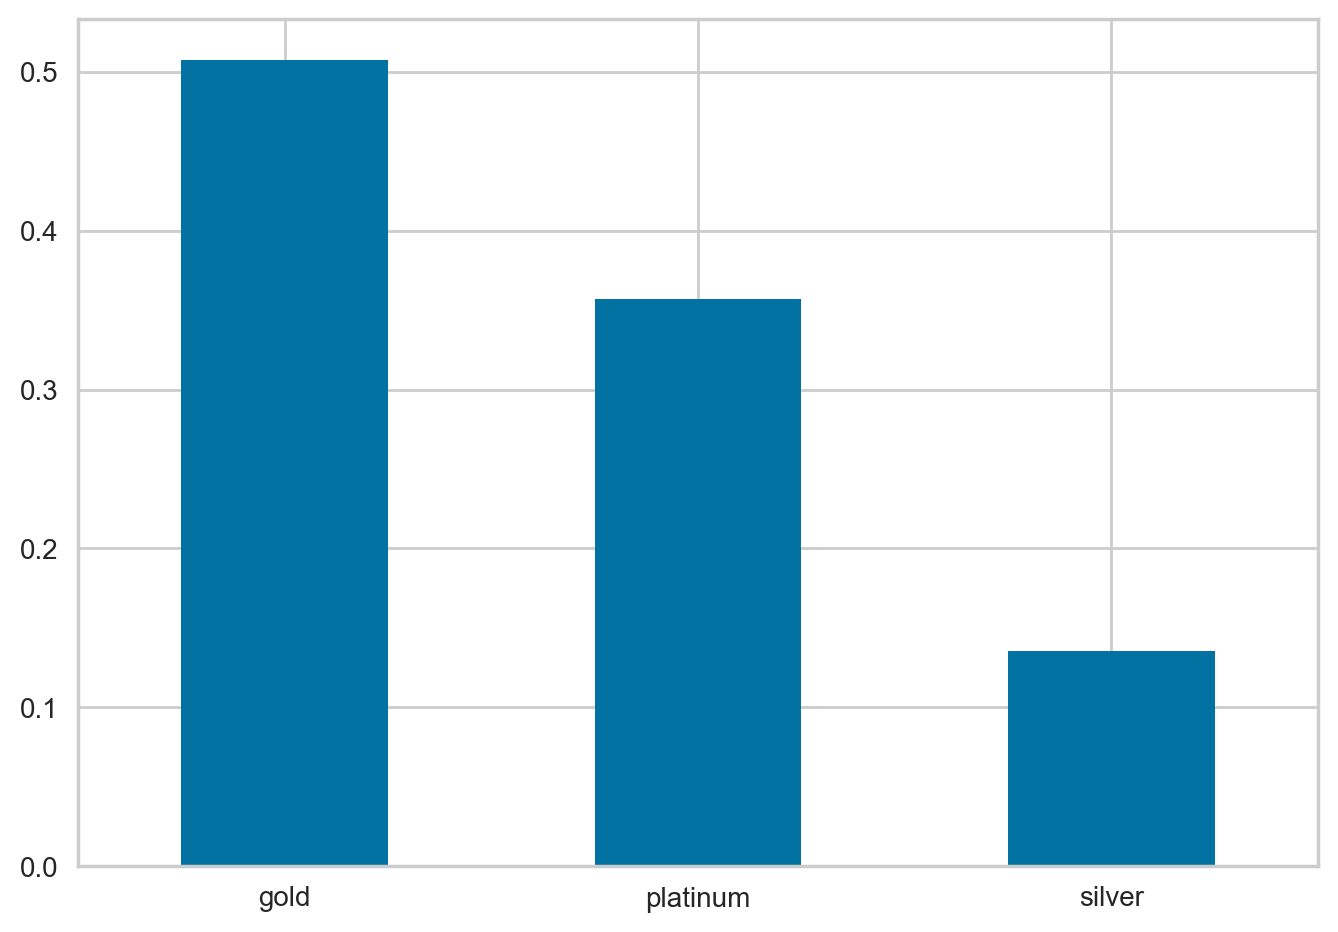

In [126]:
clu3['RFM_class'].value_counts(1).plot.bar(rot=0) #

In [147]:
df.to_csv('example.csv')